In [33]:
from __future__ import division
import numpy as np
from numpy import fft
from scipy import signal, ndimage, misc, fftpack
import bitarray
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
IMG_DIR = 'C:/Users/arak/Desktop/EE123/proj/img/'

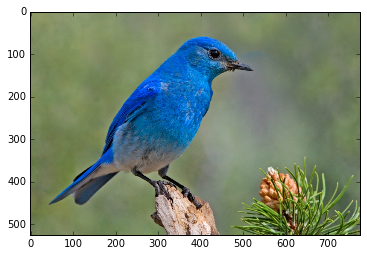

In [6]:
img = ndimage.imread(IMG_DIR+'bird.jpg')
plt.imshow(img)
plt.show()

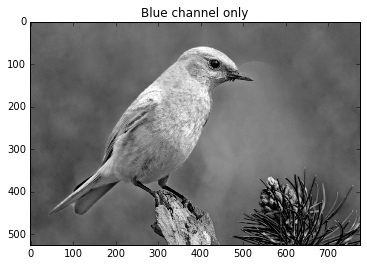

(525L, 775L)


In [21]:
imgB = img[:,:,2]
plt.imshow(imgB, cmap='gray')
plt.title("Blue channel only")
plt.show()

print imgB.shape

In [94]:
def DCT_2D(x, blockdim=(8,8)):
    out = np.zeros(x.shape)
    for i in xrange(0, x.shape[0], blockdim[0]):
        for j in xrange(0, x.shape[1], blockdim[1]):
            block = x[i:i+blockdim[0], j:j+blockdim[1]]
            block = fftpack.dct(block, type=2, axis=0)
            out[i:i+blockdim[0], j:j+blockdim[1]] = fftpack.dct(block, type=2, axis=1)
            
    return out

def IDCT_2D(x, blockdim=(8,8)):
    out = np.zeros(x.shape)
    for i in xrange(0, x.shape[0], blockdim[0]):
        for j in xrange(0, x.shape[1], blockdim[1]):
            block = x[i:i+blockdim[0], j:j+blockdim[1]]
            block = fftpack.dct(block, type=3, axis=0)
            out[i:i+blockdim[0], j:j+blockdim[1]] = fftpack.dct(block, type=3, axis=1)
            
    return out
            

In [100]:
n = np.arange(64).reshape((8,8))
nc = DCT_2D(n)
nr = IDCT_2D(nc)

print n
print nc
print nr//128   # Need to add a normalization factor???

[[ 0  1  2  3  4  5  6  7]
 [ 8  9 10 11 12 13 14 15]
 [16 17 18 19 20 21 22 23]
 [24 25 26 27 28 29 30 31]
 [32 33 34 35 36 37 38 39]
 [40 41 42 43 44 45 46 47]
 [48 49 50 51 52 53 54 55]
 [56 57 58 59 60 61 62 63]]
[[  8.06400000e+03  -4.12308673e+02   0.00000000e+00  -4.31011073e+01
    0.00000000e+00  -1.28577858e+01   0.00000000e+00  -3.24494866e+00]
 [ -3.29846939e+03   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [ -3.44808858e+02   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [ -1.02862287e+02   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00

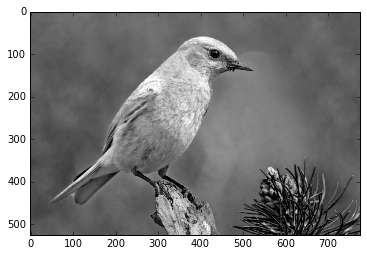

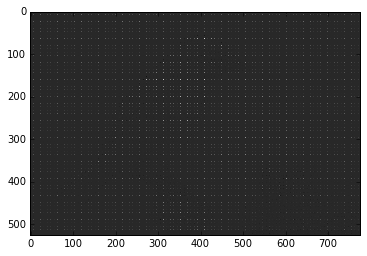

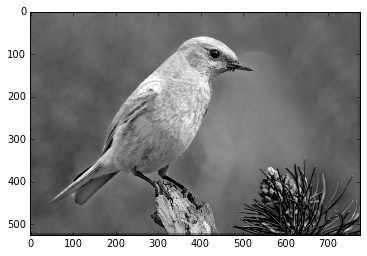

In [105]:
img_dct = DCT_2D(imgB)
img_rec = IDCT_2D(img_dct)

plt.figure()
plt.imshow(imgB, cmap='gray')

plt.figure()
plt.imshow(img_dct, cmap='gray')

plt.figure()
plt.imshow(img_rec, cmap='gray')

plt.show()